# Finding datasets of interest

In [22]:
import datetime
import pandas as pd
from erddapy import ERDDAP
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


def antarctic_map():
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(projection=ccrs.AzimuthalEquidistant(central_latitude=-60, central_longitude=-70))
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.gridlines(color='k', alpha=0.2)
    return ax

### 1. MEOPS animals

We can use ERDDAP's built in search function to find datasets that match a keyword. Let's find some animal borne sensor data

In [2]:
e_osmc = ERDDAP(
    server="https://osmc.noaa.gov/erddap",
    protocol="tabledap"
)
url = e_osmc.get_search_url(search_for="animal", response="csv")

animals = pd.read_csv(url)
animals[["Dataset ID", "Title", "Summary"]]

,Dataset ID,Title,Summary
0,MEOP_profiles,meop animal profiles,meop animal profiles. meop data from a local s...


In [3]:
e_osmc.dataset_id = animals["Dataset ID"][0]

In [4]:
e_osmc.variables = ['species']
species = e_osmc.to_pandas()

In [5]:
species

,species
0,Bearded seal
1,Blueback hood
2,Bluebacks
3,California sea lion
4,Crabeater seal
5,Fur seal
6,Green turtle
7,Grey
8,Grey seals
9,Harps


In [6]:
e_osmc.constraints = {'species=': 'Southern ellie', #'Southern ellie', 'Crabeater seal'
                 'longitude>=': -90,
                 'longitude<=': -60,
                 'latitude<=': -60
}
e_osmc.variables = ['latitude', 'longitude', 'time']
df = e_osmc.to_pandas()
df

,latitude (degrees_north),longitude (degrees_east),time (UTC)
0,-63.0186,-60.2052,2013-12-08T01:12:00Z
1,-63.0729,-60.4901,2013-12-08T05:33:00Z
2,-63.0930,-60.5763,2013-12-08T06:43:00Z
3,-63.1468,-60.8658,2013-12-08T09:41:00Z
4,-63.1652,-60.9677,2013-12-08T10:51:00Z
...,...,...,...
34127,-62.1209,-60.4423,2005-11-21T16:20:00Z
34128,-62.5409,-60.8988,2005-11-25T11:30:00Z
34129,-62.2985,-60.9728,2005-11-25T16:40:00Z
34130,-62.2816,-62.6380,2005-11-26T16:10:00Z


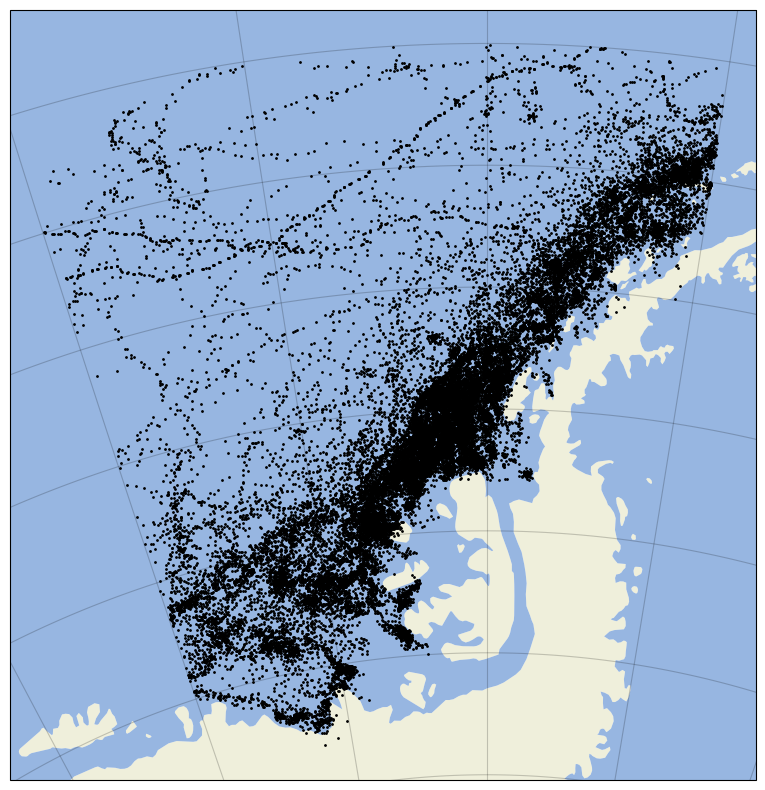

In [7]:
ax = antarctic_map()
ax.scatter(df['longitude (degrees_east)'], df['latitude (degrees_north)'], transform=ccrs.PlateCarree(), color='k', s=1)


### 2. Add argo data

We use a bounding box from the lon, lat and time of the seal data to look for co-located Argo floats on the ifremer ERDDAP

In [8]:
e_ifremer = ERDDAP(
    server="https://erddap.ifremer.fr/erddap",
    protocol="tabledap"
)
e_ifremer.dataset_id = "ArgoFloats"

In [9]:
e_ifremer.constraints = {'time>=': df["time (UTC)"].min(),
 'time<=': df["time (UTC)"].max(),
 'latitude>=':  df['latitude (degrees_north)'].min(),
 'latitude<=':  df['latitude (degrees_north)'].max(),
 'longitude>=': df['longitude (degrees_east)'].min(),
 'longitude<=': df['longitude (degrees_east)'].max(),}
e_ifremer.variables = ['latitude', 'longitude', 'time']

In [10]:
df_argo = e_ifremer.to_pandas()
df_argo

,latitude (degrees_north),longitude (degrees_east),time (UTC)
0,-61.143,-67.214,2012-03-15T13:15:47Z
1,-61.036,-66.298,2012-03-25T22:42:40Z
2,-60.922,-65.557,2012-04-04T22:47:31Z
3,-60.659,-65.147,2012-04-14T22:59:01Z
4,-60.344,-67.970,2012-03-15T20:53:00Z
...,...,...,...
2056,-60.575,-60.798,2014-10-02T18:45:39Z
2057,-60.241,-89.388,2010-06-28T02:24:10Z
2058,-60.513,-88.959,2010-07-08T02:29:14Z
2059,-60.406,-85.955,2010-10-05T23:39:04Z


In [11]:
list(df_argo)

['latitude (degrees_north)', 'longitude (degrees_east)', 'time (UTC)']

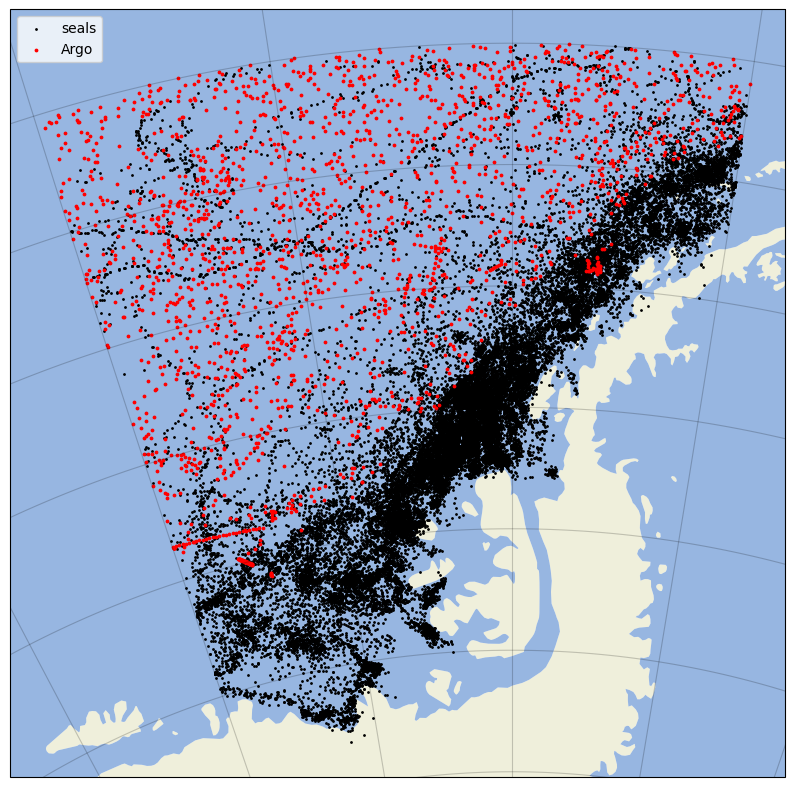

In [12]:
ax = antarctic_map()
ax.scatter(df['longitude (degrees_east)'], df['latitude (degrees_north)'], transform=ccrs.PlateCarree(), color='k', s=1, label="seals")
ax.scatter(df_argo['longitude (degrees_east)'], df_argo['latitude (degrees_north)'], transform=ccrs.PlateCarree(), color="r", s=3, label="Argo")
ax.legend()

### 3. Gridded SST

Finally, we get some matching JPL reanalysis SST data from the coastwatch ERDDAP 

In [13]:
coastwatch_e = ERDDAP(
    server="https://coastwatch.pfeg.noaa.gov/erddap",
    protocol="griddap",
)
coastwatch_e.dataset_id='jplMURSST41'
coastwatch_e.griddap_initialize() 

In [18]:
coastwatch_e.constraints = {'time>=': df["time (UTC)"].min(),
 'time<=': df["time (UTC)"].max(),
 'time_step': 365,
 'latitude>=':  df['latitude (degrees_north)'].min(),
 'latitude<=':  df['latitude (degrees_north)'].max(),
 'latitude_step': 10,
 'longitude>=': df['longitude (degrees_east)'].min(),
 'longitude<=': df['longitude (degrees_east)'].max(),
 'longitude_step': 10}

coastwatch_e.variables=['analysed_sst']

In [19]:
ds = coastwatch_e.to_xarray()

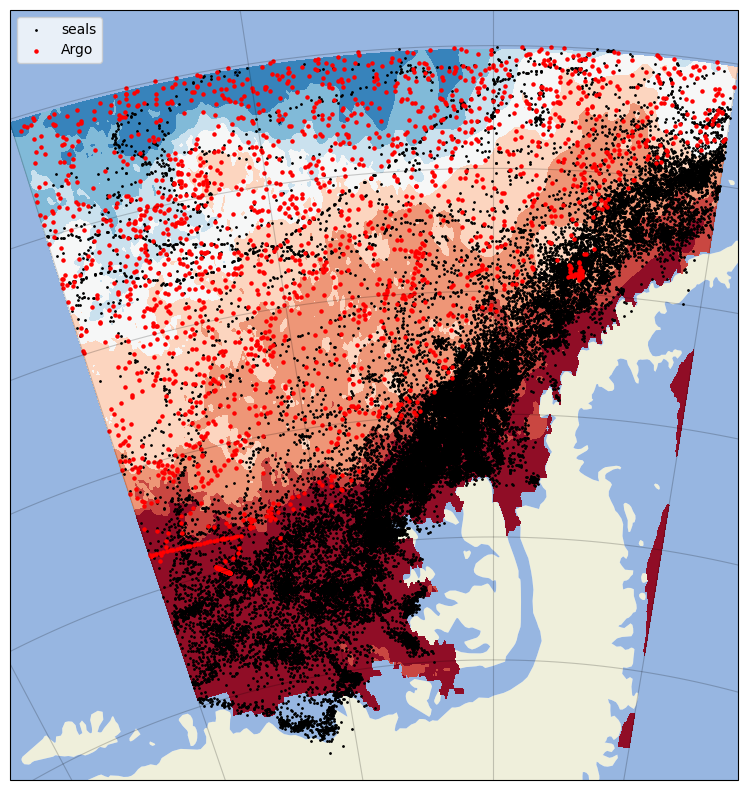

In [24]:
ax = antarctic_map()
ax.contourf(ds.longitude, ds.latitude, ds.analysed_sst[0,:,:], transform=ccrs.PlateCarree(), cmap="RdBu")
ax.scatter(df['longitude (degrees_east)'], df['latitude (degrees_north)'], transform=ccrs.PlateCarree(), color='k', s=1, label="seals")
ax.scatter(df_argo['longitude (degrees_east)'], df_argo['latitude (degrees_north)'], transform=ccrs.PlateCarree(), color="r", s=5, label="Argo")
ax.legend()

We will cover more on the use of the griddap protocol in the next session

**Bonus**: change the species to 'Crabeater seal' and re-run the notebook!

---------------------------
### References

MEOP data from meop.net

Argo data from ifremer https://erddap.ifremer.fr/erddap/tabledap/ArgoFloats.html

SST reanalysis from coastwatch https://coastwatch.pfeg.noaa.gov/erddap

More info on using ERDDAP's inbuilt search https://ioos.github.io/erddapy/01b-tabledap-output.html